# Project 3 : 2-EDA

## Problem statement

> Create the model to predict where the given post came from between cat and dog post

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import demoji
demoji.download_codes()

/var/folders/yr/lt5kfbcj2vs6bwkkyhxsp_0c0000gn/T/ipykernel_46746/3271241802.py:7: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

## Lemmatization
from nltk import word_tokenize   
from nltk.stem import WordNetLemmatizer
import re
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        regex_num_ponctuation = '(\d+)|([^\w\s])'
        regex_little_words = r'(\b\w{1,2}\b)'
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) 
                if not re.search(regex_num_ponctuation, t) and not re.search(regex_little_words, t)]
# got this from https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

## Stemming
import nltk.stem    
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])
# got this from https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn

> Snowball Stemmer: It is a stemming algorithm which is also known as the Porter2 stemming algorithm as it is a better version of the Porter Stemmer since some issues of it were fixed in this stemmer. https://www.geeksforgeeks.org/snowball-stemmer-nlp/

### Import Data from step 1

In [3]:
df_cat = pd.read_csv('../data/cats_all.csv')
df_dog = pd.read_csv('../data/dogs_all.csv')
df_cat.shape, df_dog.shape

((5999, 2), (5992, 2))

In [4]:
df_cat.head()

,subreddit,title
0,cats,Sanji kept staring at me so i seized the oppor...
1,cats,I make minimalistic clay cats. The Dinky Cats
2,cats,Why has my cat been throwing up her treats?
3,cats,My grumpy floof 💕
4,cats,When you hear the other cats being fed.


In [5]:
df_dog.head()

,subreddit,title
0,dogs,Scars on rescue dog's face?
1,dogs,Possible IMHA Diagnosis
2,dogs,Breed Suggestions?
3,dogs,I cannot tell if a dog likes me or not?
4,dogs,My 13 year old dog couldn’t jump in the bed. W...


### EDA

In [6]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5999 entries, 0 to 5998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  5999 non-null   object
 1   title      5999 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [7]:
df_dog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  5992 non-null   object
 1   title      5992 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


#### Check subreddit category

In [8]:
set(df_cat['subreddit']), set(df_dog['subreddit'])

({'cats'}, {'dogs', 'u_usa-dogs'})

#### Remove unwant subreddit category

In [9]:
df_cat = df_cat[df_cat['subreddit']=='cats']
df_dog = df_dog[df_dog['subreddit']=='dogs']
df_cat.shape, df_dog.shape

((5999, 2), (5988, 2))

### Looking for any duplicates title

In [10]:
df_cat[df_cat.duplicated(['title'])]
# got this from https://www.statology.org/pandas-find-duplicates/

,subreddit,title
116,cats,Am i feeding my cat enough?
155,cats,caption this
443,cats,The cat at my local library is so beautiful😻
461,cats,Looking for advice. GF's cat has been refusing...
538,cats,"Cats are being murdered, trapped and brutally ..."
...,...,...
5912,cats,Chunky boy had a very sleepy day today
5932,cats,He's trying out a new cookie recipe!
5950,cats,My sweet boys yogurt and orange juice
5958,cats,Help


In [11]:
df_dog[df_dog.duplicated(['title'])]

,subreddit,title
189,dogs,Quick question
275,dogs,Sudden loss of my best friend
298,dogs,My dog was diagnosed with lymphoma today and I...
422,dogs,Are there any specific dog breeds that you wou...
443,dogs,Lyme disease and confusion
...,...,...
5657,dogs,"Considering 3 breeds: Australian Shepherd, Eng..."
5697,dogs,Food aggression
5762,dogs,Had to put the best girl down yesterday.
5874,dogs,Pet Sitting


#### Remove duplicates

In [12]:
df_cat.drop_duplicates(subset="title", keep=False, inplace=True)
df_dog.drop_duplicates(subset="title", keep=False, inplace=True)
df_cat.shape, df_dog.shape

# got this from https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/

((5754, 2), (5825, 2))

> ### Until now we have data left around 5,700-5,900 posts for each category

### Distribution of post lengths

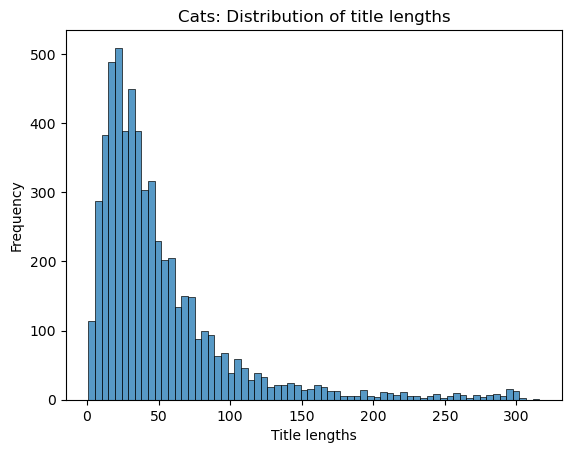

In [13]:
df_cat['title_length'] = df_cat['title'].map(lambda x: len(x))
sns.histplot(df_cat['title_length']).set(title='Cats: Distribution of title lengths', ylabel='Frequency', xlabel='Title lengths');
plt.savefig('../image/cat_distribution.png')

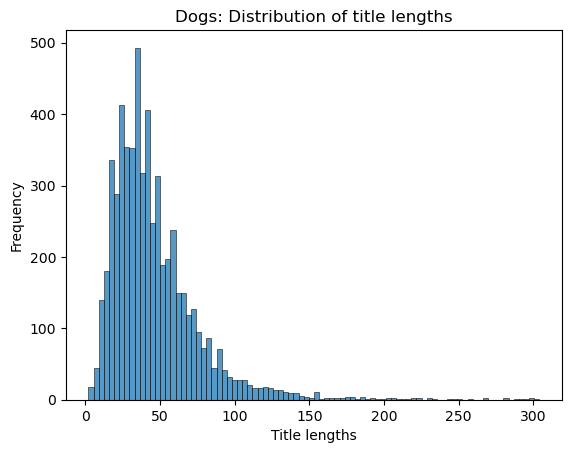

In [14]:
df_dog['title_length'] = df_dog['title'].map(lambda x: len(x))
sns.histplot(df_dog['title_length']).set(title='Dogs: Distribution of title lengths', ylabel='Frequency', xlabel='Title lengths');
plt.savefig('../image/dog_distribution.png')

In [15]:
df_cat.describe()

,title_length
count,5754.000000
mean,51.514425
std,49.399364
min,1.000000
25%,21.000000
50%,37.000000
75%,63.000000
max,316.000000


In [16]:
df_dog.describe()

,title_length
count,5825.000000
mean,46.488584
std,31.044869
min,2.000000
25%,27.000000
50%,39.000000
75%,58.000000
max,304.000000


> ### Cats have longer average post lengths than dogs.

# Word Counts by Vectorize the text

## Most common words by CountVectorizer

- ### Cats

In [17]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_cat['title'])
status_cvec = cvec.transform(df_cat['title'])
cat_cvec = pd.DataFrame(status_cvec.toarray(), columns=cvec.get_feature_names_out())

In [18]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15)

cat       1795
cats       441
just       271
like       258
little     217
old        203
does       189
kitten     181
help       167
got        163
know       162
new        160
kitty      157
love       155
boy        137
dtype: int64

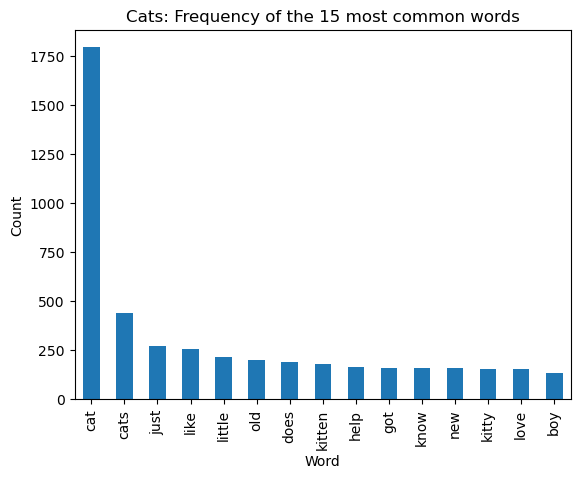

In [19]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Cats: Frequency of the 15 most common words')
plt.xlabel('Word')
plt.ylabel('Count');

- ### Dogs

In [20]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_dog['title'])
status_cvec = cvec.transform(df_dog['title'])
dog_cvec = pd.DataFrame(status_cvec.toarray(), columns=cvec.get_feature_names_out())

In [21]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15)

dog       3045
dogs       598
help       454
puppy      332
advice     282
old        240
need       223
does       171
food       168
new        158
time       150
breed      144
best       127
know       123
just       119
dtype: int64

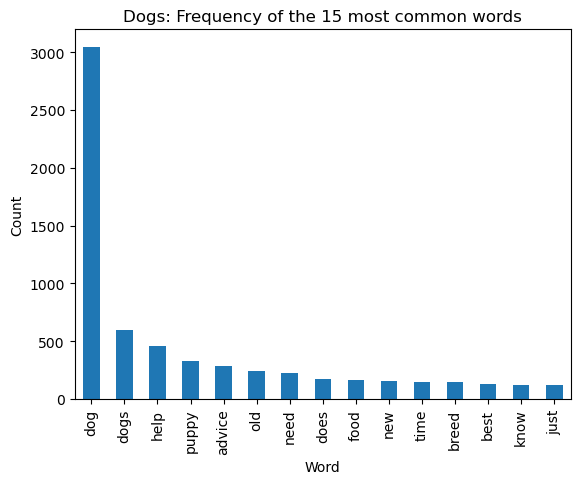

In [22]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Dogs: Frequency of the 15 most common words')
plt.xlabel('Word')
plt.ylabel('Count');

## Most common bigrams by CountVectorizer

- ### Cats

In [23]:
cvec = CountVectorizer(ngram_range=(2,2), stop_words='english')
cvec.fit(df_cat['title'])
cat_cvec = cvec.transform(df_cat['title'])
cat_cvec = pd.DataFrame(cat_cvec.toarray(), columns=cvec.get_feature_names_out())

In [24]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15)

does cat       63
year old       49
month old      33
don know       33
old cat        30
does know      30
need advice    25
new cat        24
help cat       22
years old      21
stray cat      21
months old     20
looks like     20
litter box     18
new kitten     18
dtype: int64

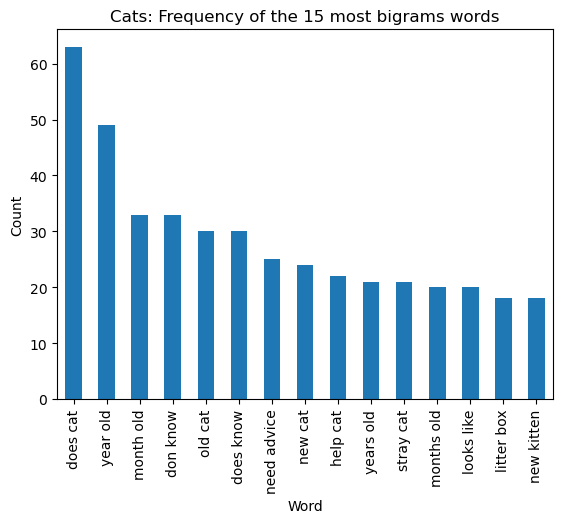

In [25]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Cats: Frequency of the 15 most bigrams words')
plt.xlabel('Word')
plt.ylabel('Count');

- ### Dogs

In [26]:
cvec = CountVectorizer(ngram_range=(2,2), stop_words='english')
cvec.fit(df_dog['title'])
dog_cvec = cvec.transform(df_dog['title'])
dog_cvec = pd.DataFrame(dog_cvec.toarray(), columns=cvec.get_feature_names_out())

In [27]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15)

year old       95
need advice    75
does dog       71
help dog       69
need help      60
old dog        57
dog food       46
dog ate        45
month old      45
don know       43
new dog        42
dog breed      38
dog won        36
daily bark     35
dog keeps      34
dtype: int64

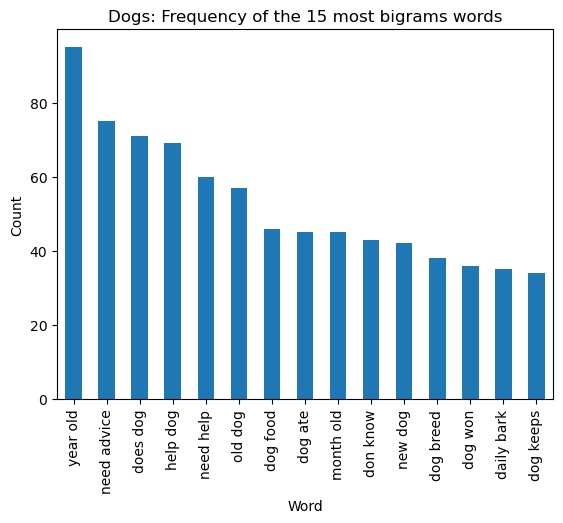

In [28]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Dogs: Frequency of the 15 most bigrams words')
plt.xlabel('Word')
plt.ylabel('Count');

## Most common words by Lemmatizing

- ### Cat

In [29]:
def preprocessor(text):
    text = text.lower()
    text = re.sub("ha", "", text)
    text = re.sub("le", "", text)
    text = re.sub("wa", "", text)
    return text
# got this from Maria'a hackathon group code

In [30]:
cvec = CountVectorizer(
    stop_words='english', 
    tokenizer=LemmaTokenizer(),
    preprocessor=preprocessor
)
cvec.fit(df_cat['title'])
cat_cvec = cvec.transform(df_cat['title'])
cat_cvec = pd.DataFrame(cat_cvec.toarray(), columns=cvec.get_feature_names_out())

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterrds', 'alys', 'anyy', 'ast', 'beforend', 'meanwhi', 'neverthess', 'pase', 'perps', 'snt', 'tord', 'tords', 'whi', 'wtever'] not in stop_words.
  warnings.warn(


In [31]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15)

cat       2198
like       312
just       270
kitten     244
love       239
litt       216
doe        209
old        199
year       180
know       175
got        171
kitty      170
help       169
new        160
day        150
dtype: int64

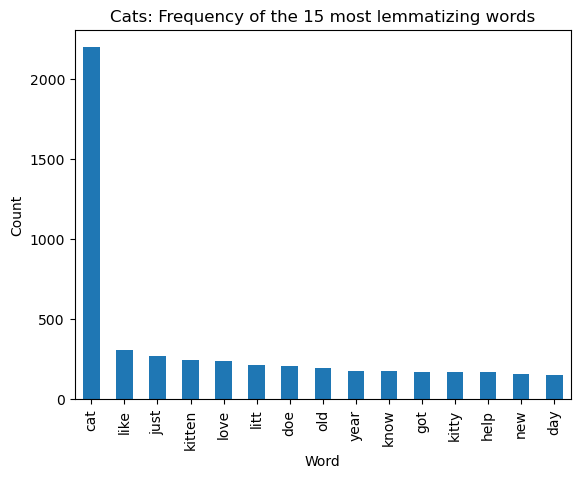

In [32]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Cats: Frequency of the 15 most lemmatizing words')
plt.xlabel('Word')
plt.ylabel('Count');

- ### Dog

In [33]:
cvec = CountVectorizer(
    stop_words='english', 
    tokenizer=LemmaTokenizer(),
    preprocessor=preprocessor
)
cvec.fit(df_dog['title'])
dog_cvec = cvec.transform(df_dog['title'])
dog_cvec = pd.DataFrame(dog_cvec.toarray(), columns=cvec.get_feature_names_out())

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterrds', 'alys', 'anyy', 'ast', 'beforend', 'meanwhi', 'neverthess', 'pase', 'perps', 'snt', 'tord', 'tords', 'whi', 'wtever'] not in stop_words.
  warnings.warn(


In [34]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15)

dog       3618
help       450
puppy      367
advice     270
need       247
old        231
breed      228
doe        184
food       173
new        158
time       157
year       139
know       126
best       125
like       122
dtype: int64

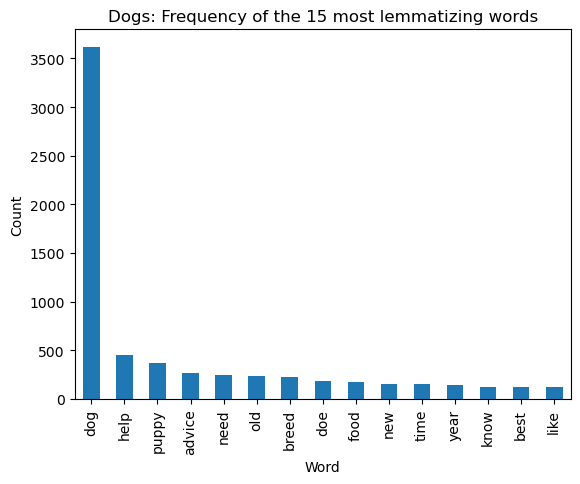

In [35]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Dogs: Frequency of the 15 most lemmatizing words')
plt.xlabel('Word')
plt.ylabel('Count');

## Most common words by Stemming

- ### Cats

In [36]:
cvec = StemmedCountVectorizer(stop_words='english')
cvec.fit(df_cat['title'])
cat_cvec = cvec.transform(df_cat['title'])
cat_cvec = pd.DataFrame(cat_cvec.toarray(), columns=cvec.get_feature_names_out())

In [37]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15)

cat       2237
like       314
love       282
just       271
kitten     251
littl      217
old        203
look       196
doe        189
help       185
year       182
know       180
kitti      178
sleep      169
want       165
dtype: int64

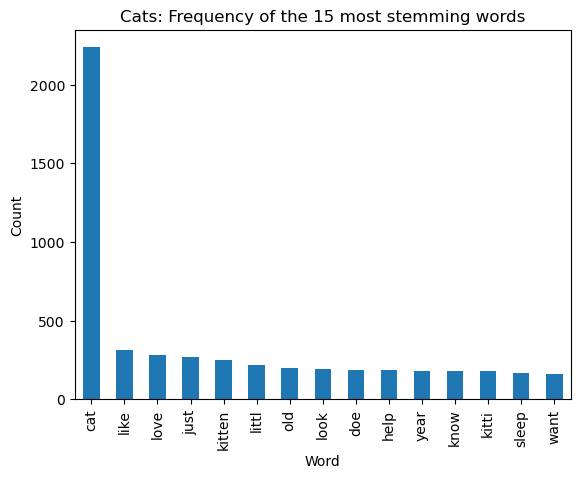

In [38]:
cat_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Cats: Frequency of the 15 most stemming words')
plt.xlabel('Word')
plt.ylabel('Count');

- ### Dogs

In [39]:
cvec = StemmedCountVectorizer(stop_words='english')
cvec.fit(df_dog['title'])
dog_cvec = cvec.transform(df_dog['title'])
dog_cvec = pd.DataFrame(dog_cvec.toarray(), columns=cvec.get_feature_names_out())

In [40]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15)

dog      3643
help      474
puppi     374
advic     284
need      280
old       241
breed     235
food      177
doe       171
time      165
new       158
year      147
train     144
know      134
like      130
dtype: int64

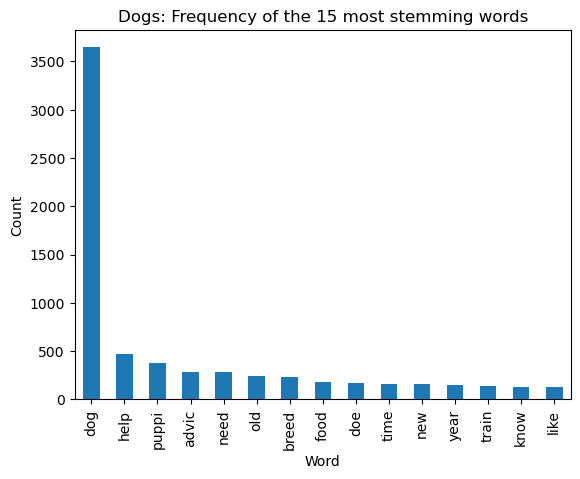

In [41]:
dog_cvec.sum(axis=0).sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Dogs: Frequency of the 15 most stemming words')
plt.xlabel('Word')
plt.ylabel('Count');

## Emoji explore

- ### Cats

In [42]:
emoji_all = []
for emoji in df_cat['title']:
    if demoji.findall(emoji):
        emoji_all.append(demoji.findall(emoji))

emoji_list = []
for e in emoji_all:
    for i in e:
        emoji_list.append(i)
print('Total emoji =', len(emoji_list))

df_emoji = pd.DataFrame([emoji_list]).T
df_emoji.value_counts().head(10)

# got this from https://www.geeksforgeeks.org/convert-emoji-into-text-in-python/
# and this https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/

Total emoji = 1026


❤️     106
😂       67
🥰       49
😍       47
😻       45
🐱       34
🤣       32
🐈‍⬛     25
😭       25
🖤       24
dtype: int64

- ### Dogs

In [43]:
emoji_all = []
for emoji in df_dog['title']:
    if demoji.findall(emoji):
        emoji_all.append(demoji.findall(emoji))

emoji_list = []
for e in emoji_all:
    for i in e:
        emoji_list.append(i)
print('Total emoji =', len(emoji_list))

df_emoji = pd.DataFrame([emoji_list]).T
df_emoji.value_counts().head(10)

Total emoji = 56


❤️    10
😭      4
♥️     2
💔      2
🙏      2
😬      2
😞      2
😍      2
🐶      2
🐕      2
dtype: int64

> Cats people use emoji in total more than dogs people by 20 times!!!

## Sentimental Analysis

In [44]:
sent = SentimentIntensityAnalyzer()

In [45]:
cat_sent = []
for word in df_cat['title']:
    cat_sent.append(sent.polarity_scores(word)['compound'])
cat_compound = sum(cat_sent)/len(cat_sent)
cat_compound

0.12247002085505745

In [46]:
dog_sent = []
for word in df_dog['title']:
    dog_sent.append(sent.polarity_scores(word)['compound'])
dog_compund = sum(dog_sent)/len(dog_sent)
dog_compund

0.02072212875536471

> Cats people are happier than dogs people by 6 times!!!

## Prepare data and Save to csv for next step

Balance data by saving 4000 for each category

In [48]:
df_cat.shape, df_dog.shape

((5754, 3), (5825, 3))

In [49]:
# Balance data by , change category cat to 1 and DOG to 0
df_nlp = pd.concat([df_cat[:5000], df_dog[:5000]], ignore_index=True).drop(columns='title_length')
df_nlp['subreddit'] = df_nlp['subreddit'].map({'cats':1, 'dogs':0}) #1=cats, 0=dogs
df_nlp.to_csv('../data/nlp_cat_dog.csv', index=False)

### As seen from EDA, There are many similar words in cats and dogs, maybe it's hard to get a good modeling